In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GroupKFold, cross_validate
from sklearn.gaussian_process.kernels import Matern, RBF

from spe.mse_estimator import ErrorComparer
from spe.data_generation import gen_rbf_X, gen_matern_X, create_clus_split, gen_cov_mat

import matplotlib.pyplot as plt

## Setup

In [20]:
nx = 100
ny = 100

n = nx * ny
p = 30
s = 30

In [29]:
xs = np.linspace(0, 50, nx)
ys = np.linspace(0, 50, ny)
c_x, c_y = np.meshgrid(xs, ys)
c_x = c_x.flatten()
c_y = c_y.flatten()
coord = np.stack([c_x, c_y]).T

In [36]:
Sigma = gen_cov_mat(c_x, c_y, RBF(length_scale=.5))
Chol = np.linalg.cholesky(Sigma + np.eye(n))

In [38]:
Sigma[:10, 0]

array([1.00000000e+00, 6.00404295e-01, 1.29949664e-01, 1.01389764e-02,
       2.85167907e-04, 2.89131069e-06, 1.05676022e-08, 1.39234139e-11,
       6.61306194e-15, 1.13226225e-18])

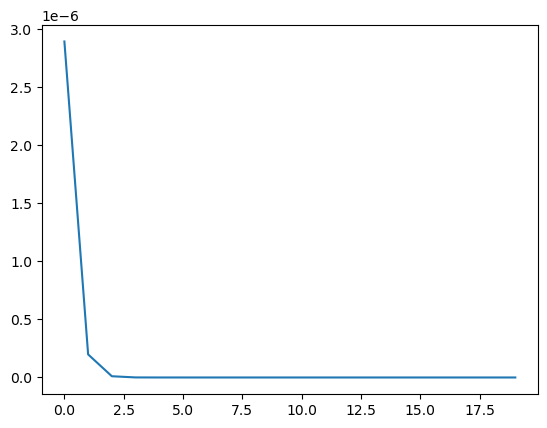

In [31]:
plt.plot(Sigma[10:30,0])

## Generate Gaussian X, Y

In [23]:
X = gen_rbf_X(c_x, c_y, p)
# X = gen_matern_X(c_x, c_y, p, length_scale=1, nu=1)
# X = np.random.randn(n,p)

beta = np.zeros(p)
idx = np.random.choice(p,size=s)
beta[idx] = np.random.uniform(-1,1,size=s)

In [24]:
Y = X@beta + Chol @ np.random.randn(n)

In [63]:
tr_idx = np.random.choice(n, size=int(.01*n), replace=False)
tr_bool = np.zeros(n, dtype=bool)
tr_bool[tr_idx] = True

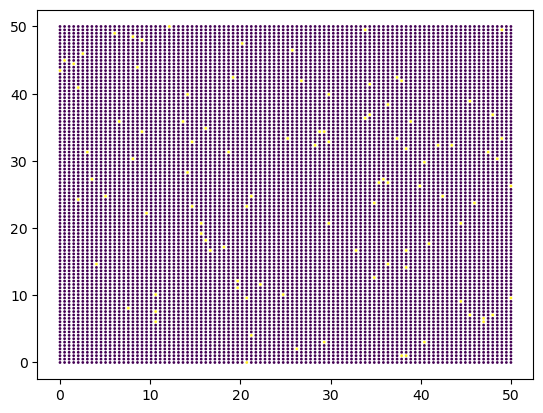

In [64]:
plt.scatter(c_x, c_y, c=tr_bool, label=tr_bool, s=1)


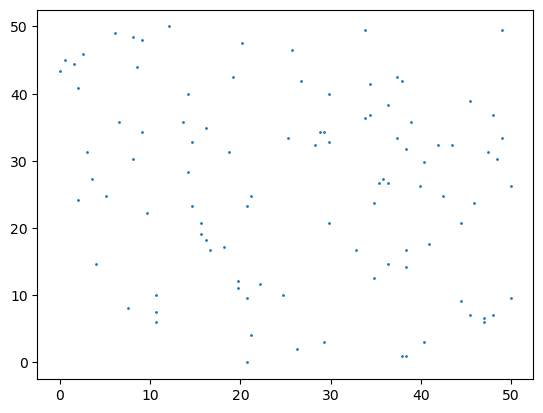

In [65]:
plt.scatter(c_x[tr_bool], c_y[tr_bool], s=1)


In [66]:
Loc = np.stack([c_x, c_y]).T
m = np.sum(Loc**2, axis=1)
D = (-2 * Loc.dot(Loc.T) + m).T + m
D = 0.5 * (D + D.T)
D = np.maximum(D, 0)  ## sometimes gets values like -1e-9
D = np.sqrt(D)

In [70]:
(D[tr_bool,:][:, ~tr_bool].min(0) > 5).sum(), (D[tr_bool,:][:, ~tr_bool].min(0) > 5).mean()

(799, 0.08070707070707071)

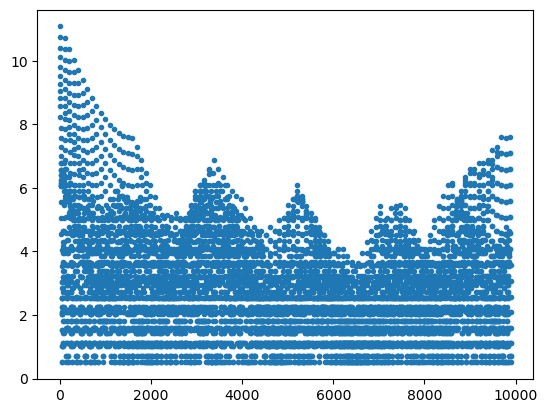

In [71]:
plt.plot(D[tr_bool,:][:, ~tr_bool].min(0), '.')

In [89]:
def BLOOSplitter(c_x, c_y, d=5):

    Loc = np.stack([c_x, c_y]).T
    m = np.sum(Loc**2, axis=1)
    D = (-2 * Loc.dot(Loc.T) + m).T + m
    D = 0.5 * (D + D.T)
    D = np.maximum(D, 0)  ## sometimes gets values like -1e-9
    D = np.sqrt(D)
    
    for i in np.arange(len(c_x)):
        ts_idx = np.zeros(len(c_x), dtype=bool)
        ts_idx[i] = True
    
        tr_idx = D[ts_idx,:] > d
        yield tr_idx, ts_idx

def BLOOCV(X, y):
    return cross_validate(LinearRegression(), X, y, cv=BLOOSplitter(), scoring='neg_mean_squared_error')

def ErrXY(X, y, tr_idx):
    m = LinearRegression()
    m.fit(X[tr_idx], y[tr_idx])
    return np.mean((y[~tr_idx] - m.predict(X[~tr_idx]))**2)

def ErrX(X, beta, Chol, tr_idx, niter=100):
    errs = np.zeros(niter)
    for i in np.arange(niter):
        Y = X@beta + Chol @ np.random.randn(n)
        errs[i] = ErrXY(X, Y, tr_idx)
    return np.mean(errs)

def AvgErr(c_x, c_y, p, beta, Chol, tr_idx, niter=100):
    errs = np.zeros(niter)
    for i in np.arange(niter):
        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        errs[i] = ErrXY(X, Y, tr_idx)
    return np.mean(errs)

In [111]:
kfcverr = -kFoldCV(X[tr_bool], Y[tr_bool])['test_score'].mean()

In [112]:
errxy = ErrXY(X, Y, tr_bool)

In [113]:
errx = ErrX(X, beta, Chol, tr_bool)

In [114]:
avgerr = AvgErr(c_x, c_y, p, beta, Chol, tr_bool)

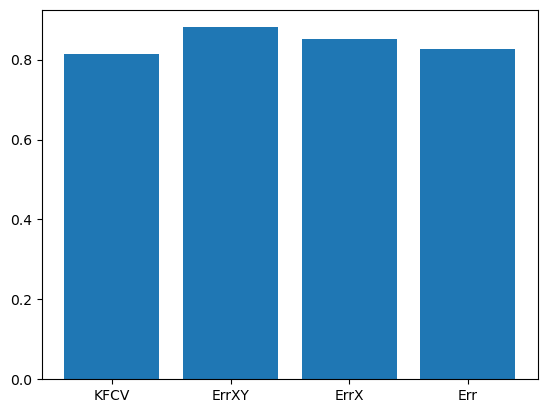

In [115]:
fig, ax = plt.subplots()
ax.bar(x=np.arange(4),height=[kfcverr, errxy, errx, avgerr])
ax.set_xticks(np.arange(4), labels=['KFCV', 'ErrXY', 'ErrX', 'Err'])

In [116]:
[kfcverr, errxy, errx, avgerr]


[0.813461744225388, 0.8808537622967731, 0.8527279933487076, 0.8253868641217689]

In [119]:
def sim(c_x, c_y, n, p, beta, Chol, nsims=100):
    res = np.zeros((4,nsims))
    
    for i in np.arange(nsims):
        if i % 10 == 0: 
            print(i)
            
        tr_idx = np.random.choice(n, size=int(.2*n), replace=False)
        tr_bool = np.zeros(n, dtype=bool)
        tr_bool[tr_idx] = True

        X = gen_rbf_X(c_x, c_y, p)
        Y = X@beta + Chol @ np.random.randn(n)
        
        res[0,i] = -kFoldCV(X[tr_bool], Y[tr_bool])['test_score'].mean()

        res[3,i] = ErrXY(X, Y, tr_bool)

        res[2,i] = ErrX(X, beta, Chol, tr_bool)

        res[1,i] = AvgErr(c_x, c_y, p, beta, Chol, tr_bool)
        
    return res

In [ ]:
res = sim(c_x, c_y, n, p, beta, Chol, 100)

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(res)
ax.set_xticks(np.arange(4), labels=['KFCV', 'Err', 'ErrX', 'ErrXY'])